<a href="https://colab.research.google.com/github/MohammadBaghbanzadeh/Anne_Shirley_Quotes/blob/main/Anne_Shirley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bing Crawler**

In [ ]:
import argparse
import hashlib
import imghdr
from os import makedirs
from os.path import exists, join, splitext
import pickle
import posixpath
import re
import signal
import socket
import threading
import time
from urllib.parse import quote, quote_plus, urlsplit, urlunsplit
from urllib.request import Request, urlopen
from io import BytesIO
import random
import sys
import pickle
import uuid

In [ ]:
# config
socket.setdefaulttimeout(2)

To manage concurrent processes, we need to
    synchronize these variables in all functions, 
    so we define them as global variables.

In [ ]:
output_dir = '/content/drive/MyDrive/Crawled_Imgaes'  # default output dir
seen_links = []
md5_of_images = {}
in_progress_threads = 0

The key is 'User-Agent' and its value is a string that
    represents the user agent for a web browser.

In [ ]:
url_header = {
    'User-Agent':'Mozilla/5.0 (X11; Linux x86_64; rv:88.0) Gecko/20100101 Firefox/88.0'
}

Encoding URL

    URL encoding helps to ensure that URLs 
    are properly formatted and can be correctly 
    interpreted by web servers and browsers

In [ ]:
def url_encoder(url):
    scheme, netloc, path, query, fragment = list(urlsplit(url))
    
    path = quote(path)
    query = quote_plus(path)
    fragment = quote(fragment)
    
    return urlunsplit((shceme, netloc, path, query, fragment))

In [ ]:
def download(number_sema: threading.Semaphore, resource_sema: threading.Semaphore, url: str, output_dir: str, limit: int):
    global seen_links
    global md5_of_images
    global in_progress_threads
    global url_header

    if url in seen_links:
        # print('SKIP: Already checked url, skipping')
        return

    # Acquire the lock for the number_sema semaphore to limit the number of concurrent downloads
    number_sema.acquire()

    in_progress_threads += 1
    
    # Initialize a flag to keep track of whether the resource_sema semaphore has been acquired or not
    acquired_resource_sema = False

    path = urlsplit(url).path

    # Extracts the filename and extension from the URL path
    name, ext = splitext(posixpath.basename(path))
    
    # If there is no file name in the URL path, generate a random unique identifier to use as the file name
    if not name:
        # if path and name are empty (e.g. https://sample.domain/abcd/?query)
        name = str(uuid.uuid4())
    else:
        # Remove any leading or trailing whitespace characters from the file name
        name = name.strip()

    """
    instead of going to 
                        "www.ñandu.com", 
    we go to 
                        "www.nandu.com" 
    instead, by the following code:
    """  
    try:
        url.encode('ascii')
    except UnicodeEncodeError:  # the url contains non-ascii characters
        url = url_encoder(url)

    

    try:
        request = Request(url, None, url_header)
        image = urlopen(request).read()
        
        # Identify the type of the image stored as bytes in a BytesIO object using imghdr module
        # and assign the detected image type to the image_type variable.
        imgtype = imghdr.what(BytesIO(image), image)
        
        if not imgtype:
            # print('SKIP: Invalid image, not saving ' + name)
            return

        # Attach a file extension based on an image header
        if not ext:
            ext = 'jpg' if imgtype == 'jpeg' else imgtype

        filename = name + '.' + ext

        if hashlib.md5(image).hexdigest() in md5_of_images:
            # print('SKIP: Image is a duplicate, not saving ' + filename)
            return

        
        # Check if file with same name already exists in output directory
        i = 0
        while exists(join(output_dir, filename)):
            # If file exists, increment index and update filename
            i += 1
            filename = str(name) + "-" + str(index) + "." + str(ext)

        # Updating the dictionary and adding name of the file which is created
        md5_of_images[hashlib.md5(image).hexdigest()] = filename

        resource_sema.acquire()
        acquired_resource_sema = True

        # Stop crawling if we achieved the number of images we wanted.
        # and also stop crawling if there is no limit for crawling.
        if limit is not None and len(seen_links) >= limit:
            return

        with open(join(output_dir, filename), 'wb') as file:
            file.write(image)

        print(" OK : " + filename)
        seen_links.append(url)
    except Exception as e:
        print("FAIL: " + name, str(e))
    finally:
        number_sema.release()
        if acquired_resource_sema:
            resource_sema.release()
        in_progress_threads -= 1


In [ ]:
def images_searched_by_keyword(number_sema: threading.Semaphore, resource_sema: threading.Semaphore, keyword: str,
                            output_dir: str, filters: str, limit: int):
    global seen_links
    global md5_of_images
    global in_progress_threads
    global url_header
    current = 1
    last = ''
    while True:
        time.sleep(0.1)

        request_url = 'https://www.bing.com/images/async?q=' + quote_plus(keyword) + '&first=' + str(
            current) + '&count=35&qft=' + ('' if filters is None else filters)
        request = Request(request_url, None, headers=url_header)
        response = urlopen(request)
        html = response.read().decode('utf8')
        links = re.findall('murl&quot;:&quot;(.*?)&quot;', html)
        try:
            if links[-1] == last:
                return
            for index, link in enumerate(links):
                if limit is not None and len(seen_links) >= limit:
                    exit(0)
                t = threading.Thread(target=download, args=(number_sema, resource_sema, link, output_dir, limit))
                t.start()
                current += 1
            last = links[-1]
        except IndexError:
            print('FAIL: No search results for "{0}"'.format(keyword))
            return

In [ ]:
def backup_history(*args):
    global output_dir
    global seen_links
    global md5_of_images
    global in_progress_threads
    global url_header
    download_history = open(join(output_dir, 'download_history.pickle'), 'wb')
    pickle.dump(seen_links, download_history)
    copied_md5_of_images = dict(
        md5_of_images)  # We are working with the copy, because length of input variable for pickle must not be changed during dumping
    pickle.dump(copied_md5_of_images, download_history)
    download_history.close()
    print('history_dumped')
    if args:
        exit(0)

In [ ]:
def Bing_Crawler(keyword: str):
    global output_dir
    global seen_links
    global md5_of_images
    global url_header
    
    # Define default values
    number_of_threads = 20
    large_image_filter = "+filterui:imagesize-large"
    filters = ''
    limit = None
    
    # Get input values from user
    search_string = keyword
    
    # Set up file paths and directories
    if not exists(output_dir):
        makedirs(output_dir)
    output_sub_dir = join(output_dir, search_string.strip().replace(' ', '_'))
    if not exists(output_sub_dir):
        makedirs(output_sub_dir)
        
    # Load previous download history
    try:
        download_history = open(join(output_dir, 'download_history.pickle'), 'rb')
        seen_links = pickle.load(download_history)
        md5_of_images = pickle.load(download_history)
        download_history.close()
    except (OSError, IOError):
        seen_links = []
        
    # Set up semaphores for threading
    number_sema = threading.BoundedSemaphore(number_of_threads)
    resource_sema = threading.Semaphore()
    
    # Search for images using the specified keyword and filters
    images_searched_by_keyword(number_sema, resource_sema, search_string, output_sub_dir, filters, limit)
    
    # Save download history
    backup_history()

In [ ]:
# query = input("Enter the sentence you want to have that images: ")
query = "Anne shirley quotes"
Bing_Crawler(query)

 OK : 2370767-Anne-Shirley-Quote-We-can-t-always-take-the-most-obvious-road-in..jpg
 OK : 1515943-Anne-Shirley-Quote-I-went-looking-for-my-dreams-outside-of-myself..jpg
 OK : 1912837-Anne-Shirley-Quote-I-went-looking-for-my-dreams-outside-of-myself..jpg
 OK : 2456136-Anne-Shirley-Quote-Just-as-soon-as-you-attain-to-one-ambition-you..jpg
 OK : 5104670-Anne-Shirley-Quote-Oh-I-know-I-ll-improve-It-s-just-that-my-life..jpg
 OK : 2990328-Anne-Shirley-Quote-But-if-you-only-knew-how-many-things-I-want-to..jpg
 OK : 2297757-Anne-Shirley-Quote-I-went-looking-for-my-dreams-outside-of-myself..jpg
 OK : 1912838-Anne-Shirley-Quote-I-went-looking-for-my-dreams-outside-of-myself..jpg
 OK : 4716328-Anne-Shirley-Quote-I-went-looking-for-my-dreams-outside-of-myself..jpg
 OK : 5104669-Anne-Shirley-Quote-Oh-I-know-I-ll-improve-It-s-just-that-my-life..jpg
 OK : 2297753-Anne-Shirley-Quote-I-went-looking-for-my-dreams-outside-of-myself..jpg
 OK : 4716327-Anne-Shirley-Quote-I-went-looking-for-my-dreams-outsid

# **Text Extractor From Image**

In [ ]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pytesseract
from PIL import Image

In [ ]:
def extract_text_from_image(image_path):
  # Open the image file
  image = Image.open(image_path)
  
  # Convert the image to grayscale
  image = image.convert('L')

  # Extract the text from the image using Tesseract
  text = pytesseract.image_to_string(image)

  return text

In [ ]:
!apt-get update
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev
!pip install pytesseract

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove

In [ ]:
img_name = "youd-find-it-easier-to-be-bad-than-good-if-you-had-red-hair-people-who-havent-red-hair-dont-know-quote-1..jpg"
img_path = "/content/drive/MyDrive/Crawled_Imgaes/Anne_shirley_quotes/" + img_name

In [ ]:
img_text = extract_text_from_image(img_path).replace('\n', ' ').lower()
print("\'" + img_text + "\'")

'   you'd find it easier to be bad than good if you had red hair... people who haven’t red hair don’t know what trouble is.  anne shirley  picture quotes. com.     picturequ@tes '


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import os

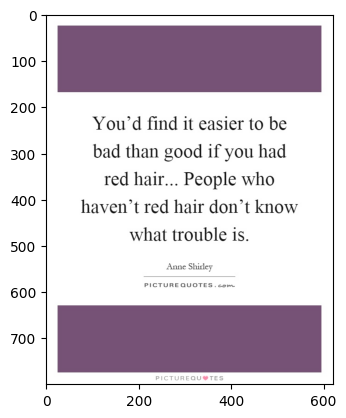

In [ ]:
img_path = "/content/drive/MyDrive/Crawled_Imgaes/Anne_shirley_quotes/" + img_name

if os.path.exists(img_path):
    img = cv2.imread(img_path)

    # Check if the image was read successfully
    if img is not None:
        # Convert BGR to RGB color format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image using Matplotlib
        plt.imshow(img)
        plt.show()
    else:
        print(f"Error: {img_path} could not be read.")
else:
    print(f"Error: {img_path} does not exist or is not readable.")

# **Spell Checker using pyspellchecker library**

In [ ]:
!pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from spellchecker import SpellChecker
import re
spell = SpellChecker()

In [ ]:
def spell_check(wrong_text):
    wrong_text = wrong_text.strip()
    wrong_text = re.sub(' +', ' ', wrong_text)
    corrected_text = wrong_text
    
    for word in corrected_text.split(" "):
      try:
        if word[-1] == '.':
          corrected_text = corrected_text.replace(word[:-1], spell.correction(word[:-1]))
        else:
          corrected_text = corrected_text.replace(word, spell.correction(word))
      except:
        continue

    return corrected_text

In [ ]:
# wrong_text = "    This is a testt to chek the          speling whic hhas spell issu."
img_text = spell_check(img_text)
print('\'', img_text, '\'')

' you'd find it easier to bead than good if you hatred hair. people who haven’t red hair don't knowwhat trouble is.  anne shirley  picture quotes. com.     picturequ@tes '


# **Grammar Checker using tool-language-python library**

In [ ]:
! pip install language-tool-python  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import language_tool_python  
  
# using the tool  
my_tool = language_tool_python.LanguageTool('en-US')  

In [ ]:
def grammar_check(my_text):
  my_text = spell_check(my_text)
  my_matches = my_tool.check(my_text)  
  text = my_tool.correct(my_text)
  return text

In [ ]:
# my_text = """LanguageTool provides utility to check grammar and spelling errors. We just have to paste the text here and click the 'Check Text' button. Click the colored phrases for for information on potential errors. or we can use this text too see an some of the issues that LanguageTool can dedect. Whot do someone thinks of grammar checkers? Please not that they are not perfect. Style problems get a blue marker: It is 7 P.M. in the evening. The weather was nice on Monday, 22 November 2021"""   
grammar_check(img_text)

"You'd find it easier to be bad than good if you had red hair. People who haven't red hair don't know what trouble is. Anne Shirley picture quotes. Com. Picturequ@tes"

# **Fuzzy search using fuzzywuzzy library**

In [ ]:
! pip install fuzzywuzzy
! pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from fuzzywuzzy import fuzz

In [ ]:
def fuzzy_search_in_files(search_str, rat):
    is_founded = False
    # Open the text file and read its contents
    path = "/content/drive/MyDrive/Anne Books"
    founded_book = set()
    for filename in os.listdir(path):
        print(f"checking --> '{filename}' ...")

        with open(os.path.join(path, filename), "r") as f:
            contents = f.readlines()

        # Loop through the lines and find a match with the search string
        for line in contents:
            # Calculate the fuzz ratio between the line and the search string
            ratio = fuzz.ratio(line.lower(), search_str.lower())
            
            # If the ratio is high enough, print the line
            if ratio > rat:
                # print('---------------')
                # print(f"Something is founded in the {filename}: \n", line)
                is_founded = True
                founded_book.add(filename)
                # print('---------------')
    return is_founded, founded_book

Testing the fuzzy search example:

In [ ]:
# Real sentece in Anne_s_House_of_Dreams.txt is:
real_text= \
"""
    "Well, thank goodness that Anne and Gilbert really are going to be
    married after all.  It's what I've always prayed for," said Mrs.
    Rachel, in the tone of one who is comfortably sure that her prayers
    have availed much.
"""
# The same sentece with that is:
same_text= \
"""
    Thank God Annie and Gilbert are finally getting married. I always pray to God that this happens.
"""
fuzzy_search_in_files(same_text, 53)

checking --> 'Anne_s_House_of_Dreams.txt' ...
checking --> 'Anne_of_Windy_Poplars.txt' ...
checking --> 'Anne_of_Ingleside.txt' ...
checking --> 'Anne_of_Avonlea.txt' ...
checking --> 'Rilla_of_Ingleside.txt' ...
checking --> 'Anne_of_Green_Gables.txt' ...
checking --> 'Rainbow_Valley.txt' ...
checking --> 'Anne_Of_The_Island.txt' ...


(True, {'Anne_s_House_of_Dreams.txt'})

In [ ]:
fuzzy_search_in_files(img_text, 50)

checking --> 'Anne_s_House_of_Dreams.txt' ...
checking --> 'Anne_of_Windy_Poplars.txt' ...
checking --> 'Anne_of_Ingleside.txt' ...
checking --> 'Anne_of_Avonlea.txt' ...
checking --> 'Rilla_of_Ingleside.txt' ...
checking --> 'Anne_of_Green_Gables.txt' ...
checking --> 'Rainbow_Valley.txt' ...
checking --> 'Anne_Of_The_Island.txt' ...


(True, {'Anne_of_Green_Gables.txt'})

# **Translate the extracted text into persian using deep_translator library**

In [ ]:
!pip install deep_translator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from deep_translator import GoogleTranslator
import re

In [ ]:
def translate_to_persian(english_text):
    # Create an instance of the GoogleTranslator class
    translator = GoogleTranslator(source='en', target='fa')

    # Call the translate() method to translate the text
    persian_text = translator.translate(english_text)

    # Return the translated text
    return persian_text


In [ ]:
def clean_text(text):
    english_pattern = r'[A-Za-z|#@$%^&*]+'
    return re.sub(english_pattern, '', text)


In [ ]:
# english_text = 'Hello World!'
persian_text = clean_text(translate_to_persian(img_text))
print(persian_text)

اگر موهای قرمز داشته باشید، بد بودن را راحت‌تر از خوب بودن می‌دانید... افرادی که موهای قرمز ندارند، نمی‌دانند مشکل چیست. نقل قول های تصویری آن شرلی  


# **Putting translated text on an empty backgound image**

In [ ]:
from PIL import Image, ImageDraw, ImageFont

In [181]:
background_image = Image.open("/content/abstract-black-background-gradient-that-looks-modern-vector.jpg")
draw = ImageDraw.Draw(background_image)

Set the font for the Persian text

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

'Anne Books'	    Crawled_Imgaes	  presian_font
'Colab Notebooks'   ImageScrawler.ipynb


In [ ]:
%cd /persian_font

[Errno 2] No such file or directory: '/persian_font'
/content/drive/MyDrive


In [182]:
font_size = 15
font = ImageFont.truetype("/content/drive/MyDrive/Colab Notebooks/Tahoma.ttf", size=font_size)

In [183]:
image_width, image_height = background_image.size
# Split the text into lines based on the image width and font size
lines = []
line = ""
for word in persian_text.split():
    if draw.textsize(line + " " + word, font=font)[0] <= image_width:
        line += " " + word
    else:
        lines.append(line.strip())
        line = word
if line:
    lines.append(line.strip())

# Calculate the total height needed for all the lines
total_text_height = len(lines) * font_size

# Position the text at the center-bottom of the image
text_x = (image_width - draw.textsize(persian_text, font=font)[0]) // 2
text_y = image_height - total_text_height - 10

# Draw each line of text
for line in lines:
    line_width, line_height = draw.textsize(line, font=font)
    draw.text((text_x, text_y), line, fill=(255, 255, 255), font=font)
    text_y += line_height

In [184]:
background_image.save("/content/newimage.jpg")